# Imports

In [1]:
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [2]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,mathcup,gamedate,winloss,minuters,pts,fgm,...,dreb,reb,ast,stl,blk,tov,pfo,plusminus,fp1,player
0,1710822472-1,https://www.nba.com/stats/players/boxscores,NaN,ATL,ATL @ LAL,03/18/2024,NaN,13,8,4,...,4,8,0,1,1,1,1,-7,22.6,Clint Capela
1,1710822472-2,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,19,8,3,...,3,4,3,2,2,1,2,-1,28.3,Mo Bamba
2,1710822472-3,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,16,11,4,...,1,2,1,1,1,0,1,1,20.9,Thomas Bryant
3,1710822472-4,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,32,20,8,...,10,13,6,0,0,4,1,-19,40.6,Bam Adebayo
4,1710822472-5,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,24,12,4,...,1,2,1,0,1,1,1,11,17.9,Buddy Hield


In [3]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [4]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

<ipython-input-4-2dcc550019b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['matchup'] = player_df['mathcup']
<ipython-input-4-2dcc550019b0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.drop(columns=['mathcup'], inplace=True)


In [5]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points)
    return total_points

In [6]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [7]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [8]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

<ipython-input-8-211a0410e864>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away


,team,gamedate,winloss,minuters,pts,fgm,fga,fgpercent,3pm,3pa,...,tov,pfo,plusminus,player,matchup,is_home,fp,opp_team,game_id,days_since
152,BOS,2024-03-17,1,35,14,6,15,40.0,2,5,...,1,0,16,Payton Pritchard,BOS @ WAS,0,28.0,WAS,WAS.BOS.2024-03-17,145
153,BOS,2024-03-17,1,23,9,3,7,42.9,3,6,...,0,0,7,Svi Mykhailiuk,BOS @ WAS,0,13.0,WAS,WAS.BOS.2024-03-17,145
154,BOS,2024-03-17,1,20,14,5,9,55.6,0,0,...,1,1,9,Luke Kornet,BOS @ WAS,0,17.0,WAS,WAS.BOS.2024-03-17,145
155,WAS,2024-03-17,0,22,8,4,7,57.1,0,2,...,0,3,-17,Johnny Davis,WAS vs. BOS,1,13.0,BOS,WAS.BOS.2024-03-17,145
156,WAS,2024-03-17,0,15,0,0,1,0.0,0,1,...,1,2,-14,Eugene Omoruyi,WAS vs. BOS,1,3.0,BOS,WAS.BOS.2024-03-17,145


In [9]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [10]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [11]:
team_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,matchup,date,winloss,min,pts,fgm,...,ftpercent,oreb,dreb,reb,ast,stl,blk,tov,pfidk,plusminus
0,1710880555-1,https://www.nba.com/stats/teams/boxscores,NaN,CLE,CLE @ IND,03/18/2024,W,240,108,38,...,71.4,9,30,39,27,8,4,14,18,5
1,1710880555-2,https://www.nba.com/stats/teams/boxscores,NaN,IND,IND vs. CLE,03/18/2024,L,240,103,42,...,62.5,14,31,45,28,8,3,11,24,-5
2,1710880555-3,https://www.nba.com/stats/teams/boxscores,NaN,DET,DET @ BOS,03/18/2024,L,240,94,36,...,86.7,8,35,43,21,6,3,13,15,-25
3,1710880555-4,https://www.nba.com/stats/teams/boxscores,NaN,BOS,BOS vs. DET,03/18/2024,W,240,119,43,...,84.6,15,38,53,30,8,8,11,9,25
4,1710880555-5,https://www.nba.com/stats/teams/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,240,98,37,...,91.7,7,39,46,23,7,12,12,16,7


In [12]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [13]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [14]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

<ipython-input-14-a5d1a32ab59e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
<ipython-input-14-a5d1a32ab59e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)


,team,matchup,date,winloss,min,pts,fgm,fga,fgpercent,3pm,...,ast,stl,blk,tov,pfidk,plusminus,gamedate,is_home,opp_team,game_id
16,LAC,LAC vs. ATL,03/17/2024,L,240,93,28,74,37.8,11,...,17,10,5,16,13,-17,2024-03-17,1,ATL,LAC.ATL.2024-03-17
17,ATL,ATL @ LAC,03/17/2024,W,240,110,41,84,48.8,17,...,32,10,7,16,22,17,2024-03-17,0,LAC,LAC.ATL.2024-03-17
18,BKN,BKN @ SAS,03/17/2024,L,265,115,47,102,46.1,8,...,29,13,5,12,20,-7,2024-03-17,0,SAS,SAS.BKN.2024-03-17
19,SAS,SAS vs. BKN,03/17/2024,W,265,122,46,99,46.5,9,...,30,6,10,18,17,7,2024-03-17,1,BKN,SAS.BKN.2024-03-17
20,ORL,ORL vs. TOR,03/17/2024,W,240,111,43,85,50.6,11,...,22,7,4,15,16,15,2024-03-17,1,TOR,ORL.TOR.2024-03-17


### Merging

In [26]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [27]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [28]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [29]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [30]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,10,30,40,24,3,5,16,20,-26,28.0
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,10,30,40,24,3,5,16,20,-26,13.0
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,10,30,40,24,3,5,16,20,-26,17.0
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,10,30,40,24,3,5,16,20,-26,29.0
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,10,30,40,24,3,5,16,20,-26,1.0


In [31]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.2 Z-Score Normalization / Standardization

In [44]:
"""
# Select the columns with player stats
stats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here

# Initialize the scaler
scaler = StandardScaler()

# Normalize the stats using Z-score normalization
df[stats_columns] = scaler.fit_transform(df[stats_columns])
"""

"\n# Select the columns with player stats\nstats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here\n\n# Initialize the scaler\nscaler = StandardScaler()\n\n# Normalize the stats using Z-score normalization\ndf[stats_columns] = scaler.fit_transform(df[stats_columns])\n"

## 1.3 One-Hot Encoding

In [32]:
# one-hot encode the categorical columns
df = pd.get_dummies(df, columns=['opp_team'])

In [33]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]

In [34]:
df.head()

,player,team,gamedate,days_since,winloss,minuters,pts,fgm,fga,fgpercent,...,opp_team_ORL,opp_team_PHI,opp_team_PHX,opp_team_POR,opp_team_SAC,opp_team_SAS,opp_team_TOR,opp_team_UTA,opp_team_WAS,fp
0,Payton Pritchard,BOS,2024-03-17,145,1,35,14,6,15,40.0,...,False,False,False,False,False,False,False,False,True,28.0
1,Svi Mykhailiuk,BOS,2024-03-17,145,1,23,9,3,7,42.9,...,False,False,False,False,False,False,False,False,True,13.0
2,Luke Kornet,BOS,2024-03-17,145,1,20,14,5,9,55.6,...,False,False,False,False,False,False,False,False,True,17.0
3,Sam Hauser,BOS,2024-03-17,145,1,23,30,10,13,76.9,...,False,False,False,False,False,False,False,False,True,29.0
4,Neemias Queta,BOS,2024-03-17,145,1,8,0,0,0,-,...,False,False,False,False,False,False,False,False,True,1.0


In [35]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
       'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov',
       'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date', 'min',
       'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'opp_team_ATL', 'opp_team_BKN',
       'opp_team_BOS', 'opp_team_CHA', 'opp_team_CHI', 'opp_team_CLE',
       'opp_team_DAL', 'opp_team_DEN', 'opp_te

## 1.4 Train-Test Split

In [ ]:
# Split the data
X = df.drop(['fp'], axis=1)  # Features
y = df['fp']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

## Wednesday March 10th fixing the fucking shit

In [25]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
       'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov',
       'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date', 'min',
       'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'opp_team_ATL', 'opp_team_BKN',
       'opp_team_BOS', 'opp_team_CHA', 'opp_team_CHI', 'opp_team_CLE',
       'opp_team_DAL', 'opp_team_DEN', 'opp_te

In [60]:
import torch
from torch.utils.data import Dataset, DataLoader

class BasketballDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        player = self.dataframe.iloc[idx]['player']
        game_date = self.dataframe.iloc[idx]['gamedate']

        player_data = self.dataframe[(self.dataframe['player'] == player) & (self.dataframe['gamedate'] <= game_date)]
        player_data = player_data.sort_values(by='gamedate')

        X = player_data.drop(['player', 'team', 'gamedate', 'game_id', 'date', 'fp', 'matchup'], axis=1).replace('-', 0).values.astype('float64')
        # X = player_data.drop(['player', 'team', 'gamedate', 'game_id', 'date', 'fp', 'matchup'], axis=1).replace('-', 0).values
        y = player_data['fp'].values

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def max_features(self):
        max_features = 0
        for i in range(len(self)):
            X, _ = self[i]
            max_features = max(max_features, X.shape[1])
        return max_features

### RNN Baseline

In [66]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

def rnn_collate(batch):
    # Separate features and targets
    X_batch = [item[0] for item in batch]
    y_batch = [item[1] for item in batch]

    # Pad sequences to have the same length
    max_seq_len = max([len(x) for x in X_batch])
    padded_X = [torch.nn.functional.pad(x, (0, 0, 0, max_seq_len - len(x))) for x in X_batch]

    # Stack padded sequences
    X_batch_padded = torch.stack(padded_X)

    # Convert targets to tensor and stack them
    y_batch_padded = torch.stack(y_batch)

    return X_batch_padded, y_batch_padded

In [62]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)

        # Forward pass through RNN layer
        out, _ = self.rnn(x, h0)

        # Take the output from the final time step
        out = out[:, -1, :]

        # Apply fully connected layer
        output = self.fc(out)

In [67]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = BasketballDataset(train_df)
test_dataset = BasketballDataset(test_df)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=rnn_collate)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=rnn_collate)

# Define the model, loss function, and optimizer
input_size = 92
hidden_size = 128
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

SimpleRNN(
  (rnn): RNN(92, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [64]:
train_dataset[0][0].shape[1]

92

In [68]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_train_loss = sum(train_losses) / len(train_losses)

    model.eval()
    test_losses = []
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            test_losses.append(loss.item())
    avg_test_loss = sum(test_losses) / len(test_losses)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


RuntimeError: stack expects each tensor to be equal size, but got [6] at entry 0 and [31] at entry 1

In [62]:
# # Step 1: Calculate Average Fantasy Points for Each Player
# avg_fp_per_player = df.groupby('player')['fp'].mean()

# # Step 2: Identify the Top 150 Players
# top_150_players = avg_fp_per_player.nlargest(150).index

# # Step 3: Filter Your Original DataFrame
# df_top_150 = df[df['player'].isin(top_150_players)]

In [63]:

# def pad_collate(batch):
#     # Filter out None items
#     batch = [item for item in batch if item is not None]
#     if not batch:
#         return torch.tensor([]), torch.tensor([])

#     # Sort the batch by sequence length (number of rows)
#     batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)

#     # Get maximum sequence length
#     max_seq_len = batch[0][0].shape[0]

#     # Pad sequences to have the same length
#     padded_X = [torch.nn.functional.pad(x.unsqueeze(0), (0, 0, 0, max_seq_len - x.shape[0])) for x, _ in batch]
#     X_batch_padded = torch.cat(padded_X, dim=0)

#     # Ensure all target tensors have the same length
#     max_target_len = max([y.shape[0] for _, y in batch])
#     padded_y = [torch.nn.functional.pad(y.unsqueeze(0), (0, 0, 0, max_target_len - y.shape[0])) for _, y in batch]

#     # Stack target tensors along a new dimension and squeeze the extra dimension
#     y_batch_padded = torch.cat(padded_y, dim=0)

#     return X_batch_padded, y_batch_padded

In [64]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# # Split the dataset into training and testing sets
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Create instances of the BasketballDataset class for training and testing
# train_dataset = BasketballDataset(train_df)
# test_dataset = BasketballDataset(test_df)

# print(len(train_dataset))
# print(len(test_dataset))

In [65]:
# # Define batch size for DataLoader
# batch_size = 64

# # Create DataLoader for training and testing datasets
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

# # for X_batch, y_batch in test_dataloader:
# #   X_batch = X_batch.reshape(X_batch.size(0), -1)
# #   print(X_batch.shape)

# # Define the decision tree regressor model
# model = DecisionTreeRegressor(random_state=42)

# # Training loop
# num_epochs = 10  # Adjust the number of epochs as needed
# for epoch in range(num_epochs):
#     # Training
#     train_losses = []
#     for X_batch, y_batch in tqdm(train_dataloader):
#         # Reshape the input tensors
#         X_batch = X_batch.reshape(X_batch.size(0), -1)
#         # print("X_batch shape:", X_batch.shape)
#         # print("y_batch shape:", y_batch.shape)
#         # Fit the model to the training data
#         model.fit(X_batch, y_batch)
#         break
#         # Compute the loss (optional)
#         # Since decision tree does not directly optimize a loss function,
#         # we don't typically compute a loss during training
#     # Validation
#     test_losses = []
#     for X_batch, y_batch in tqdm(test_dataloader):
#         # Reshape the input tensors
#         X_batch = X_batch.reshape(X_batch.size(0), -1)
#         # Predict on the test data
#         y_pred = model.predict(X_batch)
#         # Compute the loss
#         loss = mean_squared_error(y_batch.numpy(), y_pred)
#         test_losses.append(loss)
#     avg_test_loss = np.mean(test_losses)

#     # Print the average loss for each epoch
#     print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}')


## Manit Messing around with Baseline model

In [ ]:
# Step 1: Calculate Average Fantasy Points for Each Player
avg_fp_per_player = df.groupby('player')['fp'].mean()

# Step 2: Identify the Top 150 Players
top_150_players = avg_fp_per_player.nlargest(150).index

# Step 3: Filter Your Original DataFrame
df_top_150 = df[df['player'].isin(top_150_players)]

# Now, perform your train-test split on this filtered DataFrame
split_index = int(len(df_top_150) * 0.8)
train_df = df_top_150.iloc[:split_index]
test_df = df_top_150.iloc[split_index:]

In [ ]:
# df = df.sort_values(by='gamedate')
# # Example: Splitting based on a proportion
# split_index = int(len(df) * 0.8)  # For 80% train, 20% test
# train_df = df.iloc[:split_index]
# test_df = df.iloc[split_index:]

In [ ]:
from torch.utils.data import DataLoader, Dataset

class NBAFantasyDatasetForTree(Dataset):
    def __init__(self, dataframe, lookback_games=5):
        """
        Initialize the dataset.
        :param dataframe: Input DataFrame with game data.
        :param lookback_games: Number of past games to consider for each prediction.
        """
        self.data = dataframe.sort_values(by=['player', 'gamedate'])
        self.players = dataframe['player'].unique()
        self.lookback_games = lookback_games

    def __len__(self):
        return len(self.data) - self.lookback_games

    def __getitem__(self, idx):
        player_data = self.data.iloc[idx:idx + self.lookback_games]
        if len(player_data) < self.lookback_games:
            return None  # Skip if not enough data

        # Feature engineering: create aggregated features from past games
        # Exclude non-numeric columns
        exclude_columns = ['player', 'team', 'gamedate', 'game_id', 'date', 'fp', 'matchup']
        features = player_data.drop(columns=exclude_columns).replace('-', 0).astype(float)

        # Target is the 'fp' of the game immediately after the last game in player_data
        target = self.data.iloc[idx + self.lookback_games]['fp']

        return torch.tensor(features.values, dtype=torch.float), torch.tensor(target, dtype=torch.float)

In [ ]:
# Initialize the dataset
tree_dataset = NBAFantasyDatasetForTree(train_df)

# Create a DataLoader
batch_size = 32
tree_dataloader = DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def convert_dataloader_to_arrays(dataloader):
    features_list = []
    targets_list = []

    for features, targets in dataloader:
        # Flatten each sample's features
        flat_features = features.view(features.size(0), -1)  # Reshape to 2D
        features_list.append(flat_features.numpy())
        targets_list.append(targets.numpy())

    # Concatenate all batches
    all_features = np.concatenate(features_list, axis=0)
    all_targets = np.concatenate(targets_list, axis=0)

    return all_features, all_targets

train_features, train_targets = convert_dataloader_to_arrays(tree_dataloader)

# Initialize and train the model
tree_model = DecisionTreeRegressor()
tree_model.fit(train_features, train_targets)

DecisionTreeRegressor()

In [ ]:
# Assuming you have a test DataFrame: test_df
tree_test_dataset = NBAFantasyDatasetForTree(test_df)
test_dataloader = DataLoader(tree_test_dataset, batch_size=len(tree_test_dataset))  # Load all test data at once

# Convert the test DataLoader to arrays
test_features, test_targets = convert_dataloader_to_arrays(test_dataloader)


# Assuming you have a test DataFrame: test_df
tree_train_dataset = NBAFantasyDatasetForTree(train_df)
train_dataloader = DataLoader(tree_train_dataset, batch_size=len(tree_test_dataset))  # Load all test data at once

# Convert the test DataLoader to arrays
train_features, train_targets = convert_dataloader_to_arrays(train_dataloader)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
predictions = tree_model.predict(test_features)

# Calculate MSE and R-squared
mse = mean_squared_error(test_targets, predictions)
r2 = r2_score(test_targets, predictions)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.2f}")


# Predict on the test set
predictions_2 = tree_model.predict(train_features)

# Calculate MSE and R-squared
mse_2 = mean_squared_error(train_targets, predictions_2)
r2_2 = r2_score(train_targets, predictions_2)

print(f"Mean Squared Error (MSE): {mse_2:.2f}")
print(f"R-squared: {r2_2:.2f}")

Mean Squared Error (MSE): 135.17
R-squared: -0.82
Mean Squared Error (MSE): 0.00
R-squared: 1.00


In [ ]:
def calculate_accuracy_with_threshold(predictions, actuals, threshold=5.0):
    """
    Calculate the accuracy of predictions within a specified threshold.

    :param predictions: Predicted values (numpy array).
    :param actuals: Actual values (numpy array).
    :param threshold: Threshold for considering a prediction as accurate (default is 5.0).
    :return: Accuracy as a proportion of correct predictions.
    """
    # Calculate the absolute difference
    abs_diff = np.abs(predictions - actuals)

    # Determine if each prediction is within the threshold
    correct_predictions = abs_diff <= threshold

    # Calculate accuracy
    accuracy = np.mean(correct_predictions)

    return accuracy

# Using the function with your model
threshold = 7.0  # Define a threshold
accuracy = calculate_accuracy_with_threshold(predictions, test_targets, threshold)
print(f'Accuracy within a threshold of {threshold}: {accuracy:.2f}')

accuracy_2 = calculate_accuracy_with_threshold(predictions_2, train_targets, threshold)
print(f'Accuracy within a threshold of {threshold}: {accuracy_2:.2f}')


Accuracy within a threshold of 7.0: 0.47
Accuracy within a threshold of 7.0: 1.00


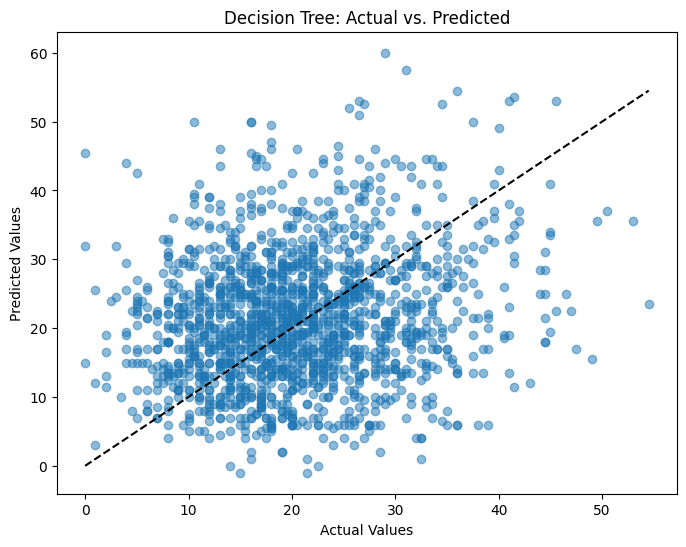

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(actuals, predictions, title='Actual vs. Predicted'):
    """
    Plot actual values vs. predicted values in a scatter plot.

    :param actuals: Actual values (numpy array).
    :param predictions: Predicted values (numpy array).
    :param title: Title of the plot (default is 'Actual vs. Predicted').
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--')  # Diagonal line
    plt.show()

# Using the function with your model's predictions
plot_actual_vs_predicted(test_targets, predictions, title='Decision Tree: Actual vs. Predicted')


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize the base model
tree_model = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(train_features, train_targets)

# Get the best parameters and the corresponding best model
best_params = grid_search.best_params_
best_tree_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)

Best parameters found:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Train the model with best parameters
best_params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}
model = DecisionTreeRegressor(**best_params)
model.fit(train_features, train_targets)

# Predict on the test set
test_predictions = model.predict(test_features)

# Calculate Mean Squared Error
mse = mean_squared_error(test_targets, test_predictions)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 81.19


In [ ]:
def calculate_accuracy_with_threshold(predictions, actuals, threshold=5.0):
    # Calculate the absolute difference
    abs_diff = np.abs(predictions - actuals)

    # Count how many predictions are within the threshold
    correct_predictions = abs_diff <= threshold

    # Calculate accuracy
    accuracy = np.mean(correct_predictions)
    return accuracy

# Calculate and print accuracy
threshold = 7.0  # You can adjust this threshold
accuracy = calculate_accuracy_with_threshold(test_predictions, test_targets, threshold)
print(f'Accuracy within a threshold of {threshold}: {accuracy:.2%}')

Accuracy within a threshold of 7.0: 55.97%


## Manit Playing about with RNNs - Model 1.0

In [ ]:
# Assuming 'df' is your original DataFrame
df = df.sort_values(by='gamedate')

# Filter Top 150 Players by Average Fantasy Points
avg_fp = df.groupby('player')['fp'].mean()
top_150_players = avg_fp.nlargest(150).index

# Apply the filter
filtered_df = df[df['player'].isin(top_150_players)]

# Calculate the index for the 80% split
split_index = int(len(filtered_df) * 0.8)

# Split the DataFrame at the 80% mark
train_df = filtered_df.iloc[:split_index]
test_df = filtered_df.iloc[split_index:]

In [ ]:
from torch.utils.data import Dataset
import torch

class NBAFantasyDataset(Dataset):
    def __init__(self, dataframe):
        """
        dataframe: Input DataFrame with game data.
        """
        self.data = dataframe
        self.players = dataframe['player'].unique()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch the target game
        target_game = self.data.iloc[idx]
        player = target_game['player']
        target_date = target_game['gamedate']

        # Fetch previous games of the player before the target game's date
        prev_games = self.data[(self.data['player'] == player) & (self.data['gamedate'] < target_date)]

        # Exclude non-numeric columns
        exclude_columns = ['player', 'team', 'gamedate', 'game_id', 'date', 'fp', 'matchup']
        features = prev_games.drop(columns=exclude_columns).replace('-', 0).astype(float)

        # Handle cases with insufficient previous games
        if len(features) == 0:
            return None

        # Target value
        target = target_game['fp']

        return torch.tensor(features.values, dtype=torch.float), torch.tensor(target, dtype=torch.float)

In [ ]:
# Initialize datasets
train_dataset = NBAFantasyDataset(train_df)
test_dataset = NBAFantasyDataset(test_df)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class EnhancedNBAFantasyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.5):
        super(EnhancedNBAFantasyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM Layer with Dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)

        # Fully Connected Layer with Batch Normalization
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_dim * 2),  # For bidirectional, output will be hidden_dim * 2
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, output_dim)
        )

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_()  # *2 for bidirectional
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])  # Take the output from the last sequence step
        return out

# Assuming 'df' is your DataFrame
feature_columns = [col for col in df.columns if col not in ['player', 'team', 'gamedate', 'game_id', 'date', 'fp', 'matchup']]
number_of_features = len(feature_columns)

# Model parameters
input_dim = number_of_features  # Replace with the number of features in your dataset
hidden_dim = 64  # Number of hidden dimensions, can be tuned
layer_dim = 2    # Number of LSTM layers, can be tuned
output_dim = 1   # Since we are predicting fantasy points

# Model instantiation remains the same
model = EnhancedNBAFantasyLSTM(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.5)

# Loss Function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be tuned

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    device = next(model.parameters()).device  # Get the device model is on

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        total_train_samples = 0

        for batch_idx, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)

            # Forward pass
            predictions = model(features)
            predictions = predictions.squeeze()  # Remove singleton dimension
            loss = criterion(predictions, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * features.size(0)
            total_train_samples += features.size(0)

        # Calculate average loss over the epoch for training data
        avg_train_loss = total_train_loss / total_train_samples

        # Evaluate on training data
        train_mae = calculate_accuracy(model, train_loader)

        # # Evaluate on validation data
        # val_mae = calculate_accuracy(model, val_loader)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training MAE: {train_mae:.4f}')


def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_mae = 0
    total_samples = 0

    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
            predictions = model(features)
            mae = torch.mean(torch.abs(predictions - targets)).item()
            total_mae += mae * features.size(0)
            total_samples += features.size(0)

    model.train()  # Set the model back to training mode
    return total_mae / total_samples

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Filter out None items
    batch = [item for item in batch if item is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([])

    features, targets = zip(*batch)

    # Pad the sequences. 'pad_sequence' automatically pads with zeros
    padded_features = pad_sequence(features, batch_first=True)

    # Convert targets to tensor
    targets_stack = torch.stack(targets)

    return padded_features, targets_stack


# Initialize the custom dataset with training data
train_dataset = NBAFantasyDataset(train_df)  # Assuming train_df is your training DataFrame

# Create the DataLoader for training data
batch_size = 32  # This can be adjusted based on your system's capabilities
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer (already defined)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader (assuming you have train_loader defined)
num_epochs = 10  # Can be tuned

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 78.4691, Training MAE: 7.0204
Epoch [2/10], Training Loss: 78.4721, Training MAE: 7.0172
Epoch [3/10], Training Loss: 78.4827, Training MAE: 7.0314
Epoch [4/10], Training Loss: 78.5281, Training MAE: 7.0279
Epoch [5/10], Training Loss: 78.4754, Training MAE: 7.0297
Epoch [6/10], Training Loss: 78.4865, Training MAE: 7.0561
Epoch [7/10], Training Loss: 78.4877, Training MAE: 7.0351
Epoch [8/10], Training Loss: 78.5058, Training MAE: 7.0205
Epoch [9/10], Training Loss: 78.4747, Training MAE: 7.0469
Epoch [10/10], Training Loss: 78.4935, Training MAE: 7.0353


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

In [ ]:
def calculate_threshold_accuracy(model, data_loader, threshold):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)

            predictions = model(features).squeeze()  # Adjust depending on your model's output shape
            total += targets.size(0)
            correct += torch.sum(torch.abs(predictions - targets) <= threshold)

    accuracy = correct / total
    return accuracy.item()

# Define a threshold value for accuracy calculation
threshold_value = 5.0  # You can adjust this based on what you consider as an acceptable error margin

# Calculate accuracy on training data
train_accuracy = calculate_threshold_accuracy(model, train_loader, threshold_value)
print(f"Training Data Accuracy within a threshold of {threshold_value}: {train_accuracy:.2f}")

# Calculate accuracy on testing data
test_accuracy = calculate_threshold_accuracy(model, test_loader, threshold_value)
print(f"Testing Data Accuracy within a threshold of {threshold_value}: {test_accuracy:.2f}")

Training Data Accuracy within a threshold of 5.0: 0.43
Testing Data Accuracy within a threshold of 5.0: 12.11
